## Final Project Submission

Please fill out:
* Student name: Caitlin Snyder
* Student pace: Self-paced
* Scheduled project review date/time: TBD
* Instructor name: Jeff Herman
* Blog post URL: https://caitlinsnyder.medium.com/exploring-movies-ff8b2d470226


*Overview*

Microsoft sees all the big companies creating original video content, and they want to get in on the fun. 

They have decided to create a new movie studio, but the problem is they don’t know anything about creating movies. 

They have hired you to help them better understand the movie industry. 

Your team is charged with doing data analysis and creating a presentation that explores what type of films are currently doing the best at the box office. 

You must then translate those findings into actionable insights that the CEO can use when deciding what type of films they should be creating.



*Requirements:*
* Your project contains at least 4 meaningful data visualizations, with corresponding interpretations. All visualizations are well labeled with axes labels, a title, and a legend (when appropriate)


* You pose at least 3 meaningful questions and answer them through EDA. These questions should be well labeled and easy to identify inside the notebook.


* Your notebook should contain 1 - 2 paragraphs briefly explaining your approach to this project.


_Questions to consider:_
* "How did you pick the question(s) that you did?"
* "Why are these questions important from a business perspective?"
* "How did you decide on the data cleaning options you performed?"
* "Why did you choose a given method or library?"
* "Why did you select those visualizations and what did you learn from each of them?"
* "Why did you pick those features as predictors?"
* "How would you interpret the results?"
* "How confident are you in the predictive quality of the results?"
* "What are some of the things that could cause the results to be wrong?"

## Approach


In reflecting on the questions that might be of interest to this client, I considered their likely motivation: profit (as opposed to, say, contributing to the post-modern cinematic arts in an understated but influential way). What are some of the areas that might inform how the client begins developing content and soliciting involvement with a view toward maximum profitability? 

I thought it might be interesting to consider how genre singularity and runtime impacted profitability--this might inform what kind of scripts the client solicits. It also seemed important to consider the names attached to productions (specifically directors), so that the client would know which influential and respected leaders in the field were worth engaging with.


## Selected Questions
1) Do multi-genre movies earn more profit on average than single-genre movies?

2) Does profit vary by runtime and audience type (domestic/foreign)?

3) How do the 10 highest profit movies compare in terms of their relationship between rating and profit? 


## Data Cleaning

### Read-in data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None

In [3]:
dfs = {}

files = {    
    'imdb_title_ratings': 'imdb.title.ratings.csv',
    'imdb_title_akas': 'imdb.title.akas.csv',
    'imdb_people': 'imdb.name.basics.csv',
    'imdb_title_basics': 'imdb.title.basics.csv',
    'imdb_title_crew': 'imdb.title.crew.csv',
    'imdb_title_principals': 'imdb.title.principals.csv',
    'rt_movie_info': 'rt.movie_info.tsv',
    'rt_reviews': 'rt.reviews.tsv',
    'bom_movie_gross': 'bom.movie_gross.csv',   
    'tmdb_movies': 'tmdb.movies.csv',
    'tn_movie_budgets': 'tn.movie_budgets.csv',
}

for k, v in files.items():
    if v.endswith('tsv'):
        dfs[k] = pd.read_csv(f'zippedData/{v}', sep='\t', encoding= 'unicode_escape') 
    elif v.endswith('csv'):
        dfs[k] = pd.read_csv(f'zippedData/{v}') 


### Preview data

In [4]:
for k in files.keys():
    print(f"\n\nDataframe {k}:\n")
    
    print("\nData types:\n")
    print(dfs[k].dtypes)  
    
    print("\nDescriptive stats:\n")
    print(dfs[k].describe())
    
    print("\nMissing values:\n")
    print(dfs[k].isna().sum())  
    print("\n*******************")



Dataframe imdb_title_ratings:


Data types:

tconst            object
averagerating    float64
numvotes           int64
dtype: object

Descriptive stats:

       averagerating      numvotes
count   73856.000000  7.385600e+04
mean        6.332729  3.523662e+03
std         1.474978  3.029402e+04
min         1.000000  5.000000e+00
25%         5.500000  1.400000e+01
50%         6.500000  4.900000e+01
75%         7.400000  2.820000e+02
max        10.000000  1.841066e+06

Missing values:

tconst           0
averagerating    0
numvotes         0
dtype: int64

*******************


Dataframe imdb_title_akas:


Data types:

title_id              object
ordering               int64
title                 object
region                object
language              object
types                 object
attributes            object
is_original_title    float64
dtype: object

Descriptive stats:

            ordering  is_original_title
count  331703.000000      331678.000000
mean        5.125872        

### Join movies with related data

In [5]:
imdb_titles_ratings = pd.merge(dfs['imdb_title_akas'], 
                   dfs['imdb_title_ratings'],
                   left_on=  ['title_id'],
                   right_on= ['tconst'], 
                   how = 'inner')

df_imdb = pd.merge(imdb_titles_ratings,
                   dfs['imdb_title_basics'],
                   left_on=  ['tconst'],
                   right_on= ['tconst'], 
                   how = 'inner')

df_imdb['year'] = df_imdb['start_year']

df_imdb = df_imdb[['title_id', 'year', 'title','averagerating', 'runtime_minutes', 'genres']]

Clean up the financial datasets

In [6]:
df_tn_budgets = dfs['tn_movie_budgets']

dollar_amts = ['production_budget', 'domestic_gross', 'worldwide_gross']
for d in dollar_amts:
    df_tn_budgets[d] = df_tn_budgets.apply(lambda row: int(row[d].replace('$','').replace(',','')), axis=1)
    
df_tn_budgets['foreign_gross'] = df_tn_budgets['worldwide_gross'] - df_tn_budgets['domestic_gross']

df_bom = dfs['bom_movie_gross']
df_bom.dropna(inplace=True)
df_bom['foreign_gross'] = df_bom.apply(
    lambda row: float(row['foreign_gross'].replace('$','').replace(',','')
    ), axis=1)



We have two separate datasets with movie financial data. Do these figures differ by more than 1% for any given movie?

In [7]:
df_financials = pd.merge(df_bom,
                   df_tn_budgets,
                   left_on= ['title'],
                   right_on= ['movie'], 
                   how = 'inner',
                 suffixes=('_bom', '_tn'))


df_financials['test_domestic'] = df_financials.apply(lambda row: \
                                                    (row['domestic_gross_bom'] <= row['domestic_gross_tn']*1.01) or \
                                                    (row['domestic_gross_bom'] >= row['domestic_gross_tn']*0.99),\
                                                    axis=1)

df_financials['test_foreign'] = df_financials.apply(lambda row: \
                                                    (float(row['foreign_gross_bom']) <= row['foreign_gross_tn']*1.01) or \
                                                    (float(row['foreign_gross_bom']) >= row['foreign_gross_tn']*0.99),\
                                                    axis=1)

domestic_inconsistency = df_financials['test_domestic'].sum() / df_financials['test_domestic'].count()
foreign_inconsistency = df_financials['test_foreign'].sum() / df_financials['test_foreign'].count()

print(f"domestic: {domestic_inconsistency}\nforeign: {foreign_inconsistency}")



domestic: 1.0
foreign: 1.0


Clean and retain the relevant financial data:

In [8]:
df_financials['worldwide_gross'] = df_financials['foreign_gross_tn'] + df_financials['domestic_gross_tn']
df_financials['foreign_profit_in_millions'] = round((df_financials['foreign_gross_tn'] - df_financials['production_budget'])/1000000,2)
df_financials['domestic_profit_in_millions'] = round((df_financials['domestic_gross_tn'] - df_financials['production_budget'])/1000000,2)
df_financials['worldwide_profit_in_millions'] = round((df_financials['worldwide_gross'] - df_financials['production_budget'])/1000000,2)

df_financials = df_financials[[
    'title',
    'year',
    'foreign_profit_in_millions',
    'domestic_profit_in_millions',
    'worldwide_profit_in_millions'
]]
df_financials.head()

,title,year,foreign_profit_in_millions,domestic_profit_in_millions,worldwide_profit_in_millions
0,Toy Story 3,2010,453.87,215.00,868.88
1,Inception,2010,382.95,132.58,675.52
2,Shrek Forever After,2010,352.51,73.74,591.24
3,The Twilight Saga: Eclipse,2010,337.57,232.53,638.10
4,Iron Man 2,2010,138.72,142.43,451.16


Add the financial data from one dataset to our movies dataset, using the financial dataset that also includes release date:

In [9]:
df_movies = df_imdb.merge(df_financials, on=['year', 'title'])

df_movies = df_movies.drop_duplicates(subset='title_id', keep="first")
df_movies.set_index('title_id', inplace=True)

df_movies.head()


,year,title,averagerating,runtime_minutes,genres,foreign_profit_in_millions,domestic_profit_in_millions,worldwide_profit_in_millions
title_id,,,,,,,,
tt0369610,2015,Jurassic World,7.0,124.0,"Action,Adventure,Sci-Fi",781.58,437.27,1433.85
tt0401729,2012,John Carter,6.6,132.0,"Action,Adventure,Sci-Fi",-65.28,-201.94,7.78
tt1194173,2012,The Bourne Legacy,6.7,135.0,"Action,Adventure,Thriller",42.15,-11.80,155.36
tt1219289,2011,Limitless,7.4,105.0,"Mystery,Sci-Fi,Thriller",49.32,52.25,128.56
tt1294226,2010,The Last Song,6.0,107.0,"Drama,Music,Romance",9.73,42.95,72.68


### Question 1: Do multi-genre movies earn more profit on average than single-genre movies?

Text(0, 0.5, 'Number of genres')

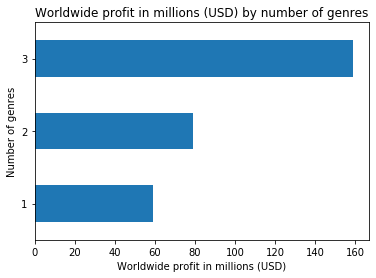

In [10]:
df_genres = df_movies.loc[df_movies['genres'].notna()]
df_genres['num_genres'] = df_genres.apply(lambda row: len(row['genres'].split(',')), axis=1)
df_genres = df_genres[['worldwide_profit_in_millions', 'num_genres']]
df_genres = df_genres.groupby('num_genres').mean()

df_genres.plot(kind="barh", legend=False)
plt.title("Worldwide profit in millions (USD) by number of genres")
plt.xlabel("Worldwide profit in millions (USD)")
plt.ylabel("Number of genres")



### Question 2: Does profit vary by runtime and audience type (domestic/foreign)?

Text(0.5, 0, 'Profit in millions (USD)')

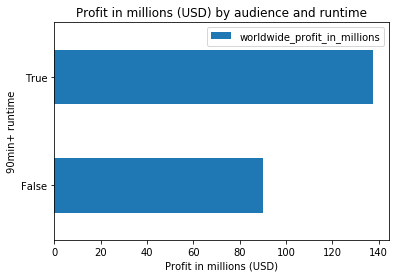

In [11]:
df_runtime = df_movies.loc[df_movies['runtime_minutes'].notna()]
df_runtime['over_90_mins'] = df_runtime.apply(lambda row: row['runtime_minutes'] > 90, axis=1)

df_runtime_worldwide = df_runtime[['worldwide_profit_in_millions', 'over_90_mins']]
df_runtime_worldwide = df_runtime_worldwide.groupby('over_90_mins').mean()

df_runtime_worldwide.plot(kind="barh")
plt.title("Profit in millions (USD) by audience and runtime")
plt.ylabel("90min+ runtime")
plt.xlabel("Profit in millions (USD)")


In [12]:
ratio_worldwide = round(df_runtime_worldwide.iloc[0] / df_runtime_worldwide.iloc[1] * 100, 2)
ratio_worldwide


worldwide_profit_in_millions    65.52
dtype: float64

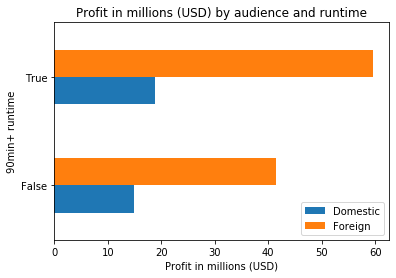

In [16]:
df_runtime_by_audience = df_runtime[['domestic_profit_in_millions', 'foreign_profit_in_millions', 'over_90_mins']]
df_runtime_by_audience = df_runtime_by_audience.groupby('over_90_mins').mean()

df_runtime_by_audience.plot(kind="barh")
plt.title("Profit in millions (USD) by audience and runtime")
plt.ylabel("90min+ runtime")
plt.xlabel("Profit in millions (USD)")
plt.legend(["Domestic", "Foreign"]);


In [14]:
ratio_domestic = round(df_runtime_by_audience.iloc[0][0] / df_runtime_by_audience.iloc[1][0] * 100, 2)
ratio_foreign = round(df_runtime_by_audience.iloc[0][1] / df_runtime_by_audience.iloc[1][1] * 100, 2)
print(f"Ratio of <= 90mins to 90min+ :")
print(f"   Domestic: {ratio_domestic}")
print(f"   Foreign: {ratio_foreign}")

Ratio of <= 90mins to 90min+ :
   Domestic: 79.33
   Foreign: 69.5


### Question 3: How do the 10 highest profit movies compare in terms of their relationship between rating and profit? 

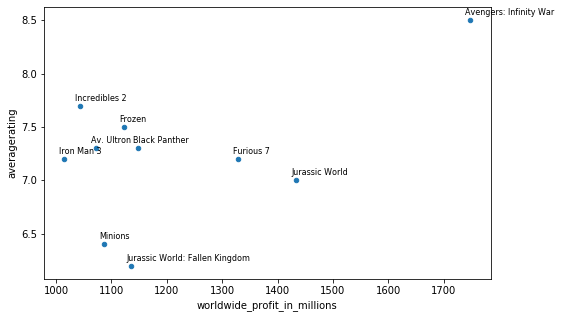

In [15]:
top_10 = df_movies.nlargest(10, ['worldwide_profit_in_millions'])

# Abbreviate for readability
top_10['title'] = top_10['title'].replace('Avengers: Age of Ultron', 'Av. Ultron')


fig, ax = plt.subplots(figsize=(8,5))
top_10.plot('worldwide_profit_in_millions', 'averagerating', kind='scatter', ax=ax)

for index, row in top_10.iterrows():
    ax.annotate(
        str(row['title']), 
        (row['worldwide_profit_in_millions'], row['averagerating']),
        xytext=(-5,5), textcoords='offset points',
                family='sans-serif', fontsize=8
    )


# Sources
https://www.shanelynn.ie/`bar-plots-in-python-using-pandas-dataframes/#dataframeplotbar
https://cmdlinetips.com/2020/06/pandas-explode-convert-list-like-column-elements-to-separate-rows/